<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_5_31_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(파이썬 딥러닝 텐서플로)
# PART 04. 합성곱 신경망(CNN)
## 04. 위성 이미지 분류
### 4-1 텐서플로 데이터셋 로드
인공위성에서 지표면을 촬용한 이미지와 토지이용분류 값이 정리되어 있는 EuroSAT 데이터셋


In [2]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# 텐서플로 데이터셋 활용
import tensorflow_datasets as tfds

In [4]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = 'dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split = ['train[:80%]','train[80%:]'],
                                       shuffle_files = True,
                                       as_supervised = True,
                                       with_info = True,
                                       data_dir = DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/incomplete.RQHZXN_2.0.0/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [5]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpto7aq_4ktfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

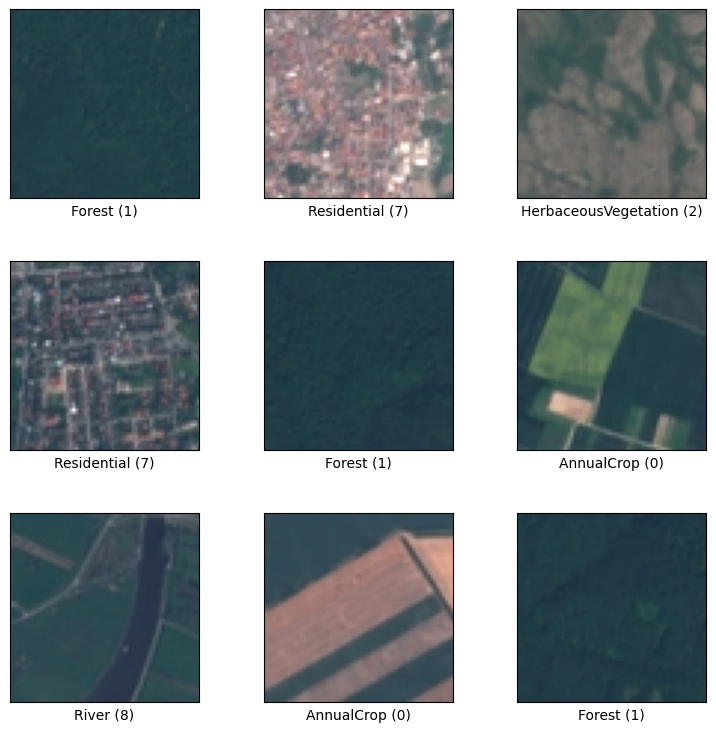

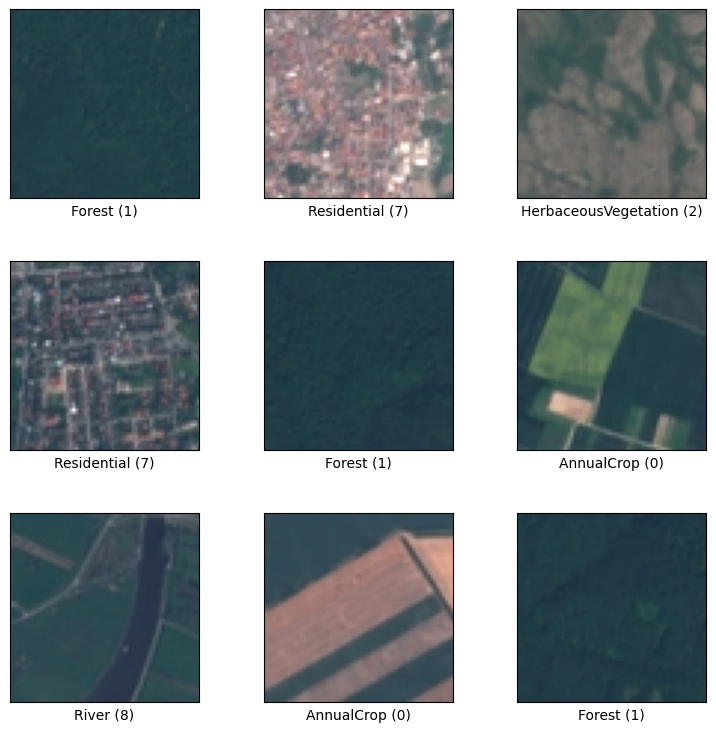

In [6]:
# 데이터 확인
tfds.show_examples(train_ds,info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
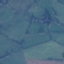
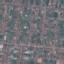
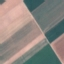
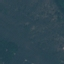
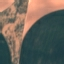
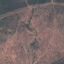
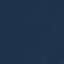
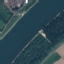
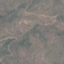
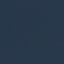

In [7]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [8]:
# 목표 클래스 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [10]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### 4-2 데이터 전처리
텐서플로 데이터셋 : 데이터 전처리에 필요한 함수들을 제공 &  텐서 연산을 효율적으로 처리할 수 있는 최적화를 지원
* map 함수 : 사용자 정의 함수를 매핑. num_parallel_calls 옵션을 오토튠으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화

In [12]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.    # 0~1 정규화, float32 변환
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### 4-3 모델 훈련 및 검증

In [13]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([

     # Convolution 층
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D((2,2)),

     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D((2,2)),

     # Classifier 출력층
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

model = build_model()

In [15]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs=5)

Epoch 1/5
338/338 [==============================] - 275s 800ms/step - loss: 1.0419 - accuracy: 0.6405 - val_loss: 0.7790 - val_accuracy: 0.7365
Epoch 2/5
338/338 [==============================] - 214s 632ms/step - loss: 0.8850 - accuracy: 0.6904 - val_loss: 0.5821 - val_accuracy: 0.8002
Epoch 3/5
338/338 [==============================] - 221s 655ms/step - loss: 0.8144 - accuracy: 0.7229 - val_loss: 0.5784 - val_accuracy: 0.8154
Epoch 4/5
338/338 [==============================] - 231s 683ms/step - loss: 0.7188 - accuracy: 0.7584 - val_loss: 0.5918 - val_accuracy: 0.8026
Epoch 5/5
338/338 [==============================] - 229s 677ms/step - loss: 0.6717 - accuracy: 0.7725 - val_loss: 0.4977 - val_accuracy: 0.8443


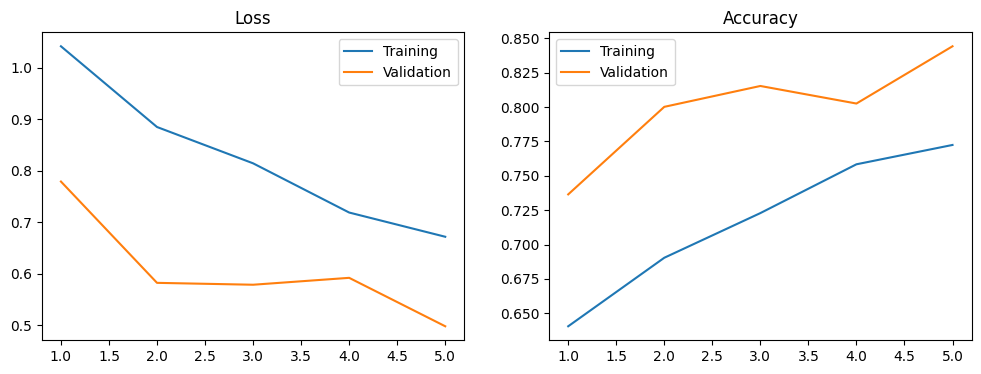

In [16]:
# 손실함수, 정확도 그래프 그리기

def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(range(1, epoch + 1), loss, label='Training')
  axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch + 1), acc, label='Training')
  axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()


plot_loss_acc(history,5)

### 4-4 데이터 증강 (Data Augmentation)
이미지 분류 문제에서 과대 적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법  
* 이미지 데이터에 여러가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식

Text(0.5, 1.0, 'Pasture')

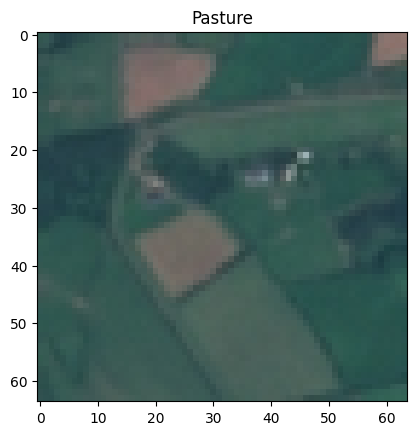

In [17]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [18]:
# 데이터 증강 전후를 비교하는 시각화 함수 정의
def plot_augmentation(original, augmented):

  fig, axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

* tf.image 모듈의 flip_left_right, flip_up_down 함수로 이미지를 좌우, 상하 방향으로 뒤집는 방법

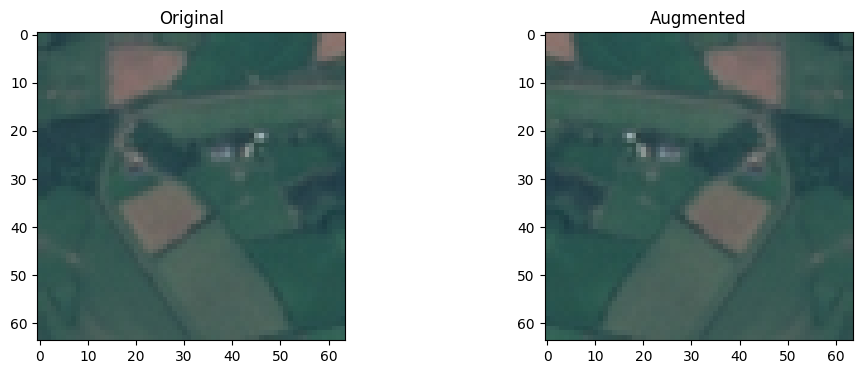

In [22]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image,lr_flip)

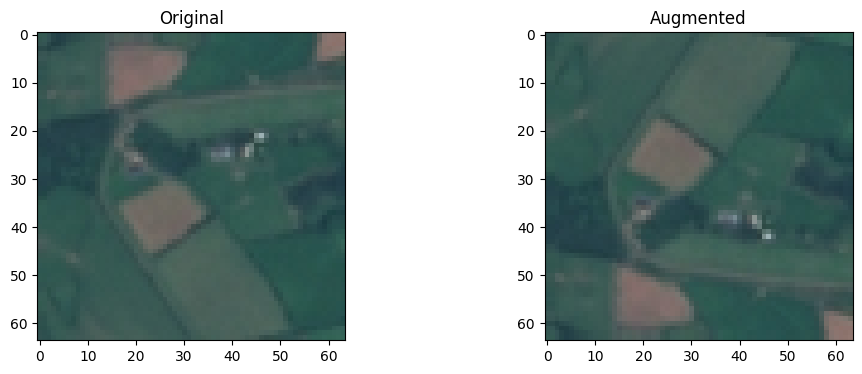

In [23]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image,ud_flip)

* rot90 함수는 이미지를 반시계 방향으로 90도 회전

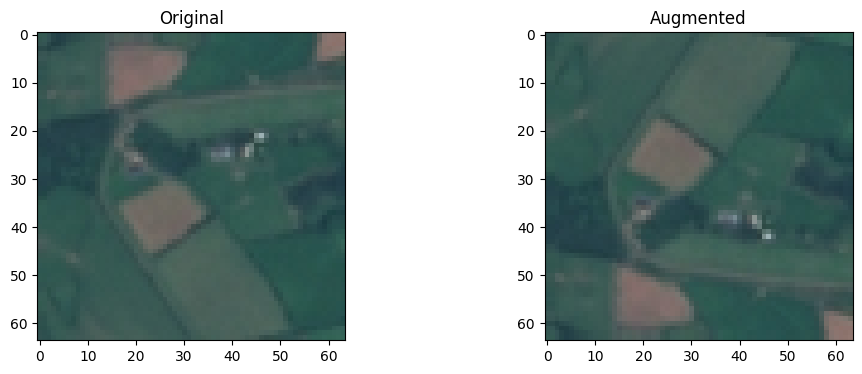

In [24]:
# 회전
rotate90 = tf.image.flip_up_down(image)
plot_augmentation(image,rotate90)

* transpose 함수는 텐서 행렬의 행과 열의 위치를 바꿔줌

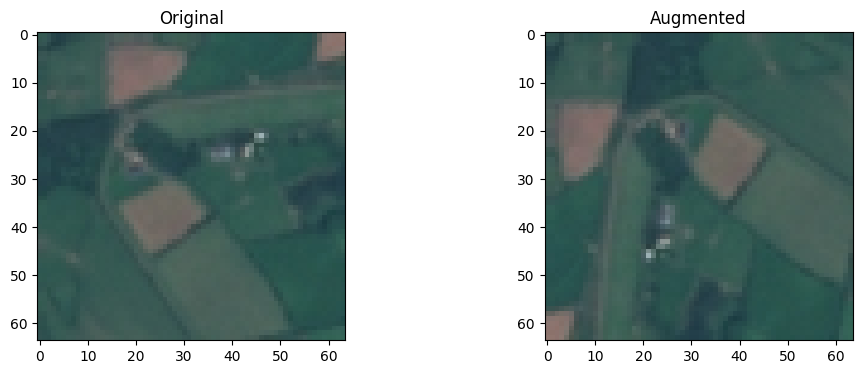

In [25]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image,transpose)

* central_crop 함수는 이미지의 중심에서 일정 부분을 잘라냄

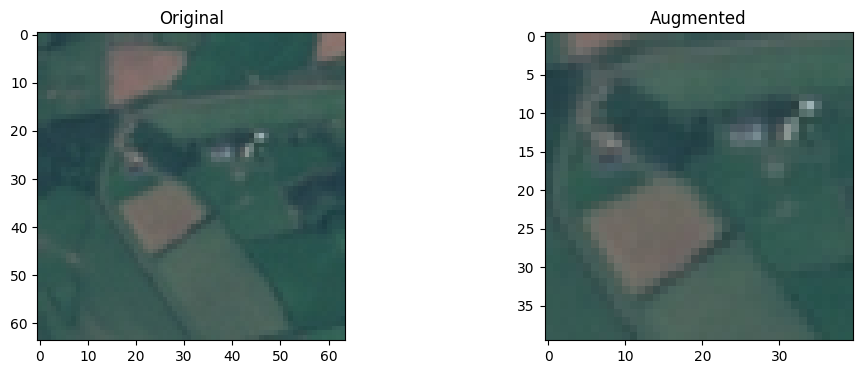

In [27]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image,crop1)

* resize_with_crop_or_pad 함수로 원본 이미지의 크기를 키우고, random_crop 함수를 사용하여 이미지를 원본 크기와 같게 자르면 이미지가 상하좌우 랜덤한 방향으로 시프트 이동한다

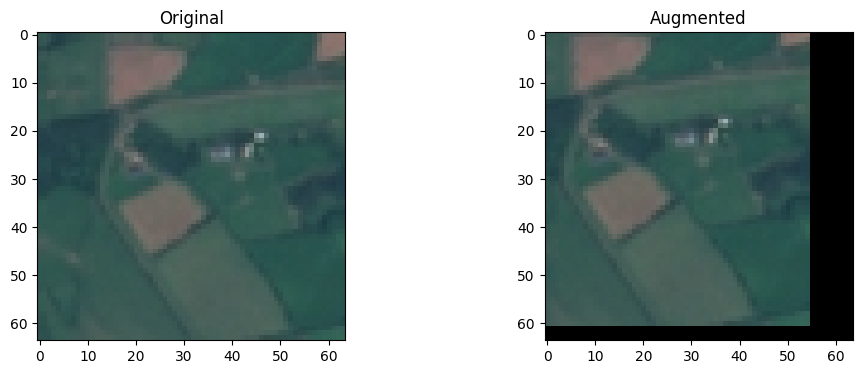

In [29]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image,crop2)

* 이미지 밝기 조정도 가능

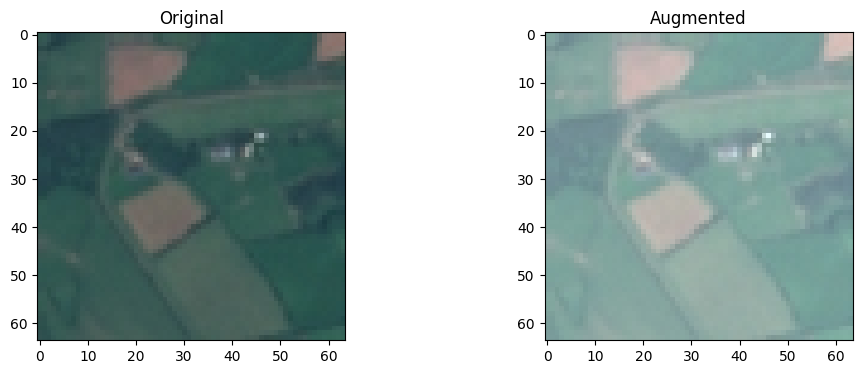

In [30]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image,brightness)

* 이미지 채도 변경

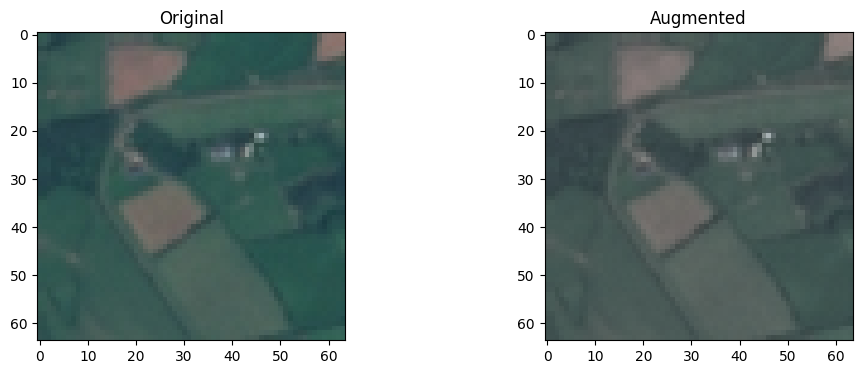

In [31]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image,saturation)

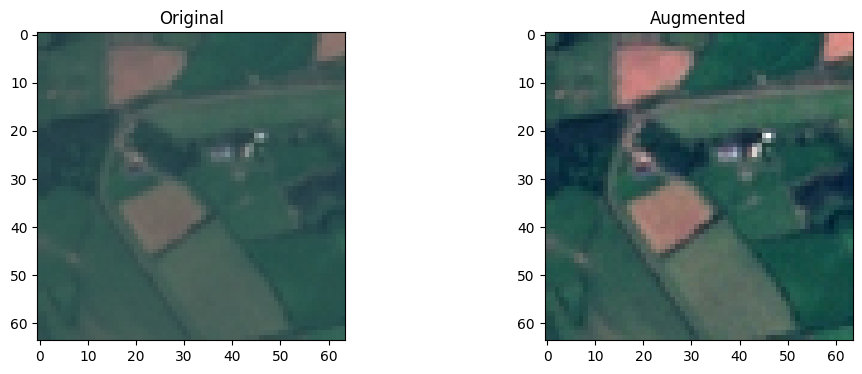

In [32]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image,contrast)

* 위 기법 중 몇가지를 선택하여 random_으로 시작하는 함수로 적용

In [34]:
# 이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image)  # 좌우 반전
  image = tf.image.random_flip_up_down(image)  # 상하 반전
  image = tf.image.random_brightness(image, max_delta=0.3)  # 밝기 변화
  image = tf.image.random_crop(image, size=[64,64,3])

  image = tf.cast(image, tf.float32)/255.  # 0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [37]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=5)

Epoch 1/5
338/338 [==============================] - 283s 829ms/step - loss: 1.8570 - accuracy: 0.2996 - val_loss: 1.8449 - val_accuracy: 0.3120
Epoch 2/5
338/338 [==============================] - 262s 775ms/step - loss: 1.5813 - accuracy: 0.3888 - val_loss: 1.3910 - val_accuracy: 0.4900
Epoch 3/5
338/338 [==============================] - 238s 703ms/step - loss: 1.4602 - accuracy: 0.4395 - val_loss: 1.1891 - val_accuracy: 0.5585
Epoch 4/5
338/338 [==============================] - 230s 681ms/step - loss: 1.3552 - accuracy: 0.4756 - val_loss: 1.4005 - val_accuracy: 0.4850
Epoch 5/5
338/338 [==============================] - 224s 660ms/step - loss: 1.3091 - accuracy: 0.4940 - val_loss: 1.1346 - val_accuracy: 0.5770


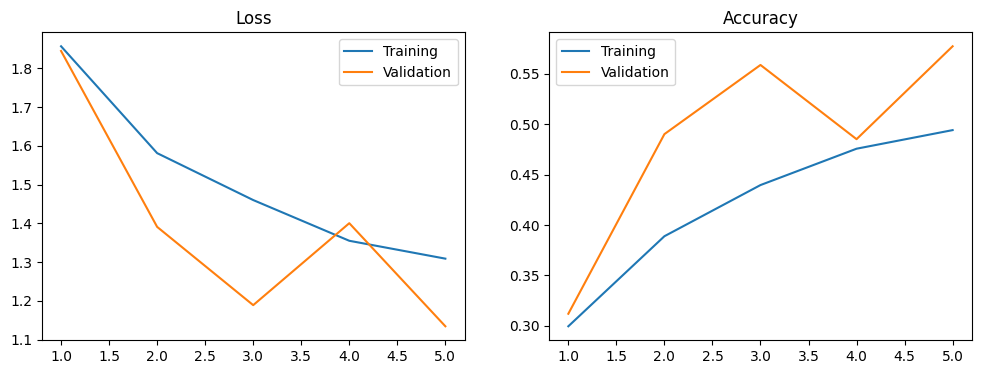

In [38]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 5)

### 4-5 ResNet 사전 학습 모델
가장 중요한 옵션은 include_top=False로 지정하여 제거된 Top 층에 우리가 해결하려는 문제에 맞는 최종 분류기를 대체해서 추가해야 함

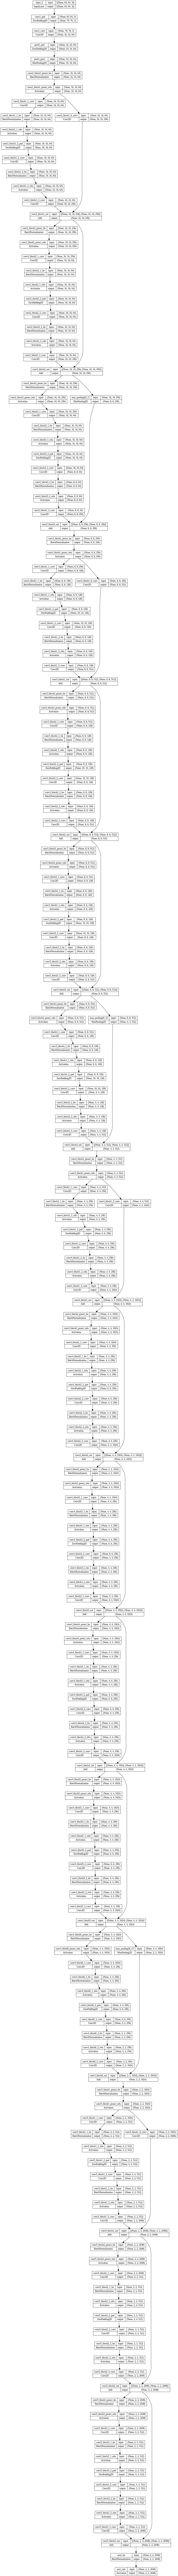

In [41]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64,64,3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [43]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([

     # Pre-trained Base
     pre_trained_base,
     # Classifier 출력층
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 10)               